#Goal : Predict Weekly sales for each store and department based on a set of given conditions

##Loading libraries

In [ ]:
# linear algebra
import numpy as np

# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

#Visualization
import seaborn as sns; 
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from IPython.display import display, Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Obtaining data

In [ ]:
#before importing the dataset download kaggle.json api from your kaggle account
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#Accept the rules of the competition before running the below compand
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 49.6MB/s]
  0% 0.00/220k [00:00<?, ?B/s]
100% 220k/220k [00:00<00:00, 68.9MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 66.9MB/s]
  0% 0.00/532 [00:00<?, ?B/s]
100% 532/532 [00:00<00:00, 465kB/s]
  0% 0.00/2.47M [00:00<?, ?B/s]
100% 2.47M/2.47M [00:00<00:00, 80.8MB/s]


In [ ]:
#Unziping files

!unzip '/content/features.csv.zip'
!unzip '/content/test.csv.zip'
!unzip '/content/train.csv.zip'
!unzip '/content/sampleSubmission.csv.zip'

Archive:  /content/features.csv.zip
  inflating: features.csv            
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


#Loading data

In [ ]:
train = pd.read_csv("/content/train.csv")
features= pd.read_csv("/content/features.csv")
stores = pd.read_csv("/content/stores.csv")
test = pd.read_csv("/content/test.csv")

In [ ]:
#View the data

train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [ ]:
features

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [ ]:
stores

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [ ]:
test

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [ ]:
#merging the features and stores to train dataset
#Using 'Store','Date' and 'IsHoliday' to join features and using 'stores' to join stores table

train_dataset = train.merge(stores, how='left',on=['Store']).merge(features, how='left',on=['Store','Date','IsHoliday'])

In [ ]:
train_dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


##Data Preprocessing

In [ ]:
#Check for missing values in training dataset
train_dataset.isnull().any()

Store           False
Dept            False
Date            False
Weekly_Sales    False
IsHoliday       False
Type            False
Size            False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI             False
Unemployment    False
dtype: bool

In [ ]:
#Check for missing values in test dataset
test.isnull().any()

Store        False
Dept         False
Date         False
IsHoliday    False
dtype: bool

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [ ]:
np.unique(train_dataset[['Type']])
#Shows that stores are classified into three types A , B and C

array(['A', 'B', 'C'], dtype=object)

In [ ]:
np.unique(train_dataset[['Store']])
#Shows there are 45 unique departments

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [ ]:
np.unique(train_dataset[['Dept']])
#Shows there are 99 unique departments

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82,
       83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
train_dataset['Temperature'].describe()

count    421570.000000
mean         60.090059
std          18.447931
min          -2.060000
25%          46.680000
50%          62.090000
75%          74.280000
max         100.140000
Name: Temperature, dtype: float64

In [ ]:
train_dataset['Weekly_Sales'].describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [ ]:
train_dataset['Fuel_Price'].describe()

count    421570.000000
mean          3.361027
std           0.458515
min           2.472000
25%           2.933000
50%           3.452000
75%           3.738000
max           4.468000
Name: Fuel_Price, dtype: float64

###Converting date to weeks and categorical values to numerical

In [ ]:
train_dataset['Week'] = pd.to_datetime(train_dataset['Date']).dt.week 
train_dataset['Year'] = pd.to_datetime(train_dataset['Date']).dt.year

#Convert type to categorical values to dummies
train_dataset['IsHoliday'] = train_dataset['IsHoliday'].astype(int)

#Convert Type to integer A=3, B=2, C=1
train_dataset.Type = train_dataset.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

train_dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Year
0,1,1,2010-02-05,24924.50,0,3,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2010
1,1,1,2010-02-12,46039.49,1,3,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,6,2010
2,1,1,2010-02-19,41595.55,0,3,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,7,2010
3,1,1,2010-02-26,19403.54,0,3,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,8,2010
4,1,1,2010-03-05,21827.90,0,3,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,0,2,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,39,2012
421566,45,98,2012-10-05,628.10,0,2,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,40,2012
421567,45,98,2012-10-12,1061.02,0,2,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,41,2012
421568,45,98,2012-10-19,760.01,0,2,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,42,2012


###Missing Value Analysis

In [ ]:
#Chekcing percentage missing values in Markdown1,2,3,4,5
round((train_dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].isna().sum()/len(train_dataset))*100,2)

MarkDown1    64.26
MarkDown2    73.61
MarkDown3    67.48
MarkDown4    67.98
MarkDown5    64.08
dtype: float64

###Holiday Analysis

As per kaggle

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [ ]:
import datetime
sb1 = datetime.date(2010, 2, 10).isocalendar()[1]
sb2 = datetime.date(2011, 2, 11).isocalendar()[1]
sb3 = datetime.date(2012, 2, 10).isocalendar()[1]
sb4 = datetime.date(2013, 2, 8).isocalendar()[1]


print('Super bowl weeks : ', sb1 , sb2,sb3,sb4)

lb1 = datetime.date(2010, 9, 10).isocalendar()[1]
lb2 = datetime.date(2011, 9, 9).isocalendar()[1]
lb3 = datetime.date(2012, 9, 7).isocalendar()[1]
lb4 = datetime.date(2013, 9, 6).isocalendar()[1]

print('Labor day weeks : ', lb1 , lb2,lb3,lb4)


tg1 = datetime.date(2010, 11, 26).isocalendar()[1]
tg2 = datetime.date(2011, 11, 25).isocalendar()[1]
tg3 = datetime.date(2012, 11, 23).isocalendar()[1]
tg4 = datetime.date(2013, 11, 29).isocalendar()[1]

print('Thanksgiving weeks : ', tg1 , tg2,tg3,tg4)

c1 = datetime.date(2010, 12, 31).isocalendar()[1]
c2 = datetime.date(2011, 12, 30).isocalendar()[1]
c3 = datetime.date(2012, 12, 28).isocalendar()[1]
c4 = datetime.date(2013, 12, 27).isocalendar()[1]

print('Christmas weeks : ', c1 , c2,c3,c4)

Super bowl weeks :  6 6 6 6
Labor day weeks :  36 36 36 36
Thanksgiving weeks :  47 47 47 48
Christmas weeks :  52 52 52 52


Some interesting notes about the result:

* All Holidays fall on the same week
* Test Data doesn't have Labor Day, so this Holiday is not very relevant
* Christmas has 0 pre-holiday days in 2010, 1 in 2011 and 3 in 2012. The model will not consider more Sales in 2012 for Test Data, so we are going to adjust it at the end, with a formula and an explanation.

##Data Visualization using tableau

In [ ]:
#https://public.tableau.com/profile/jheel.patel

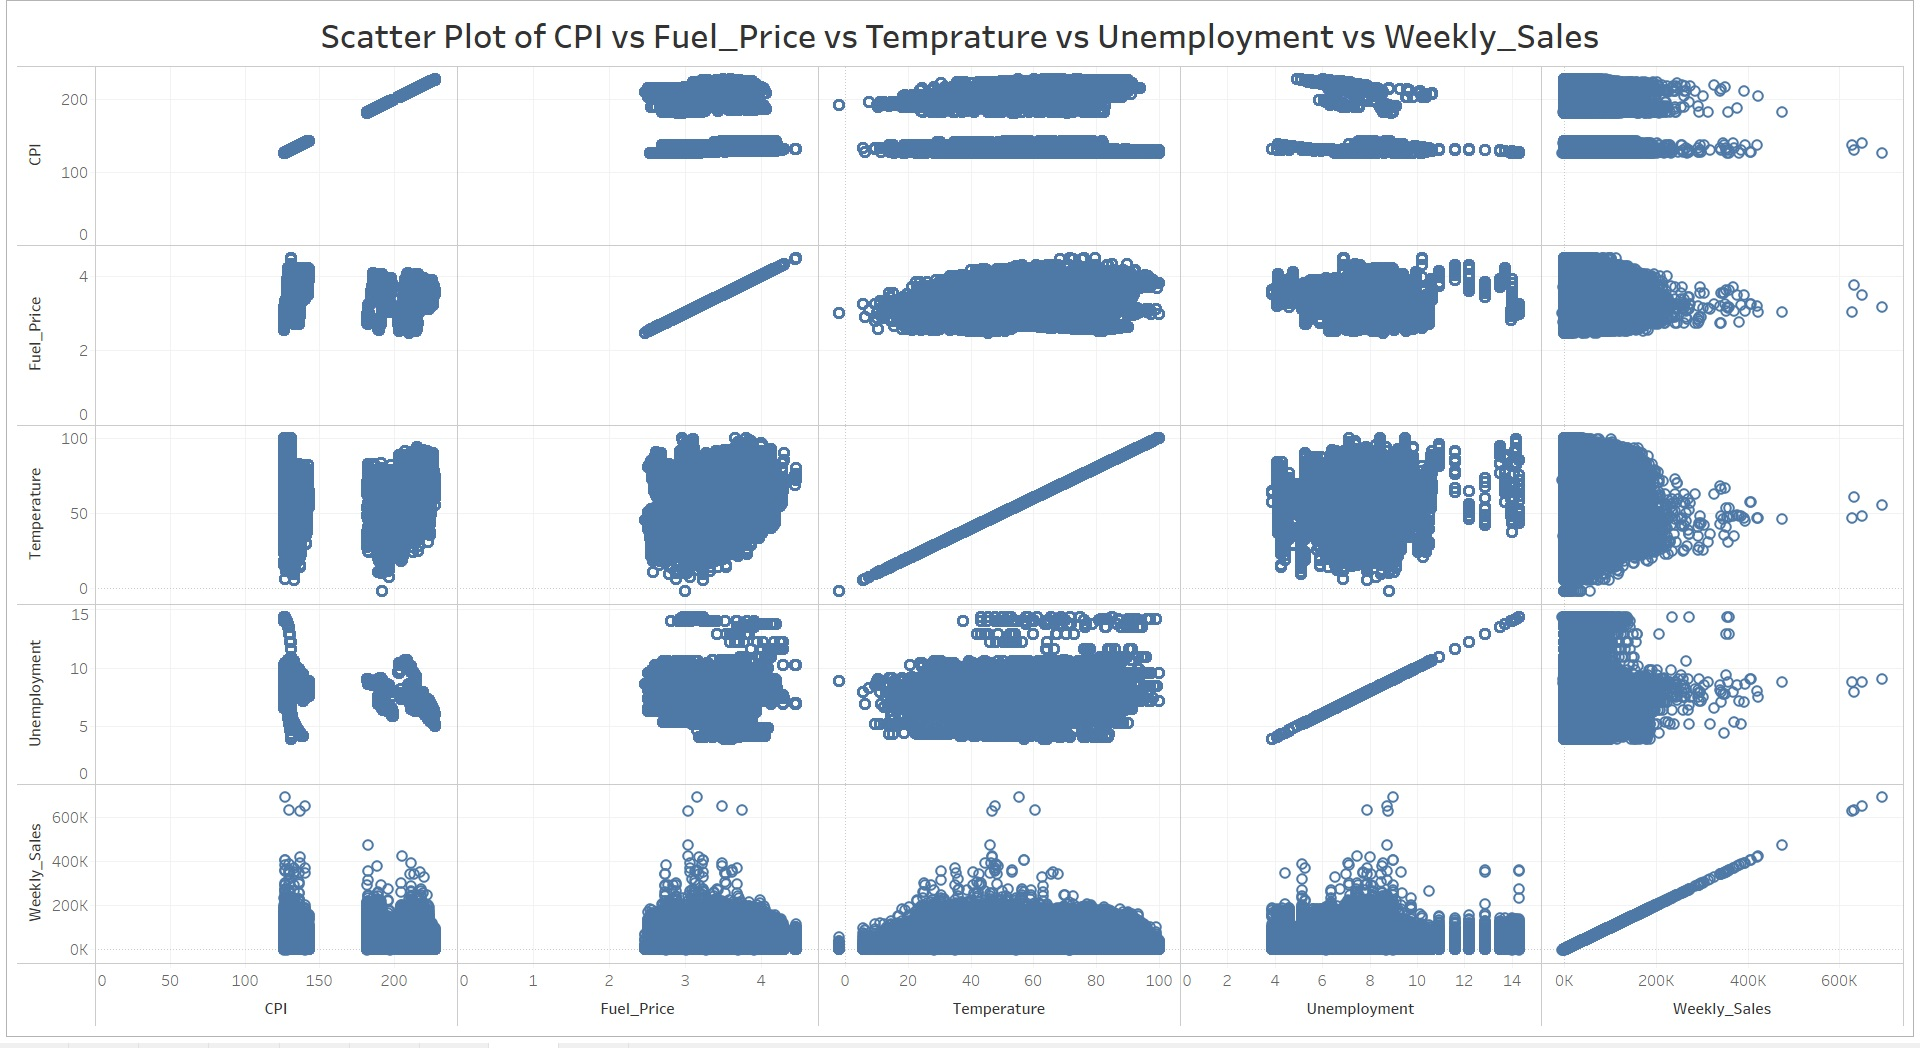

In [ ]:
display(Image(filename='/content/Scatter plot.jpg'))

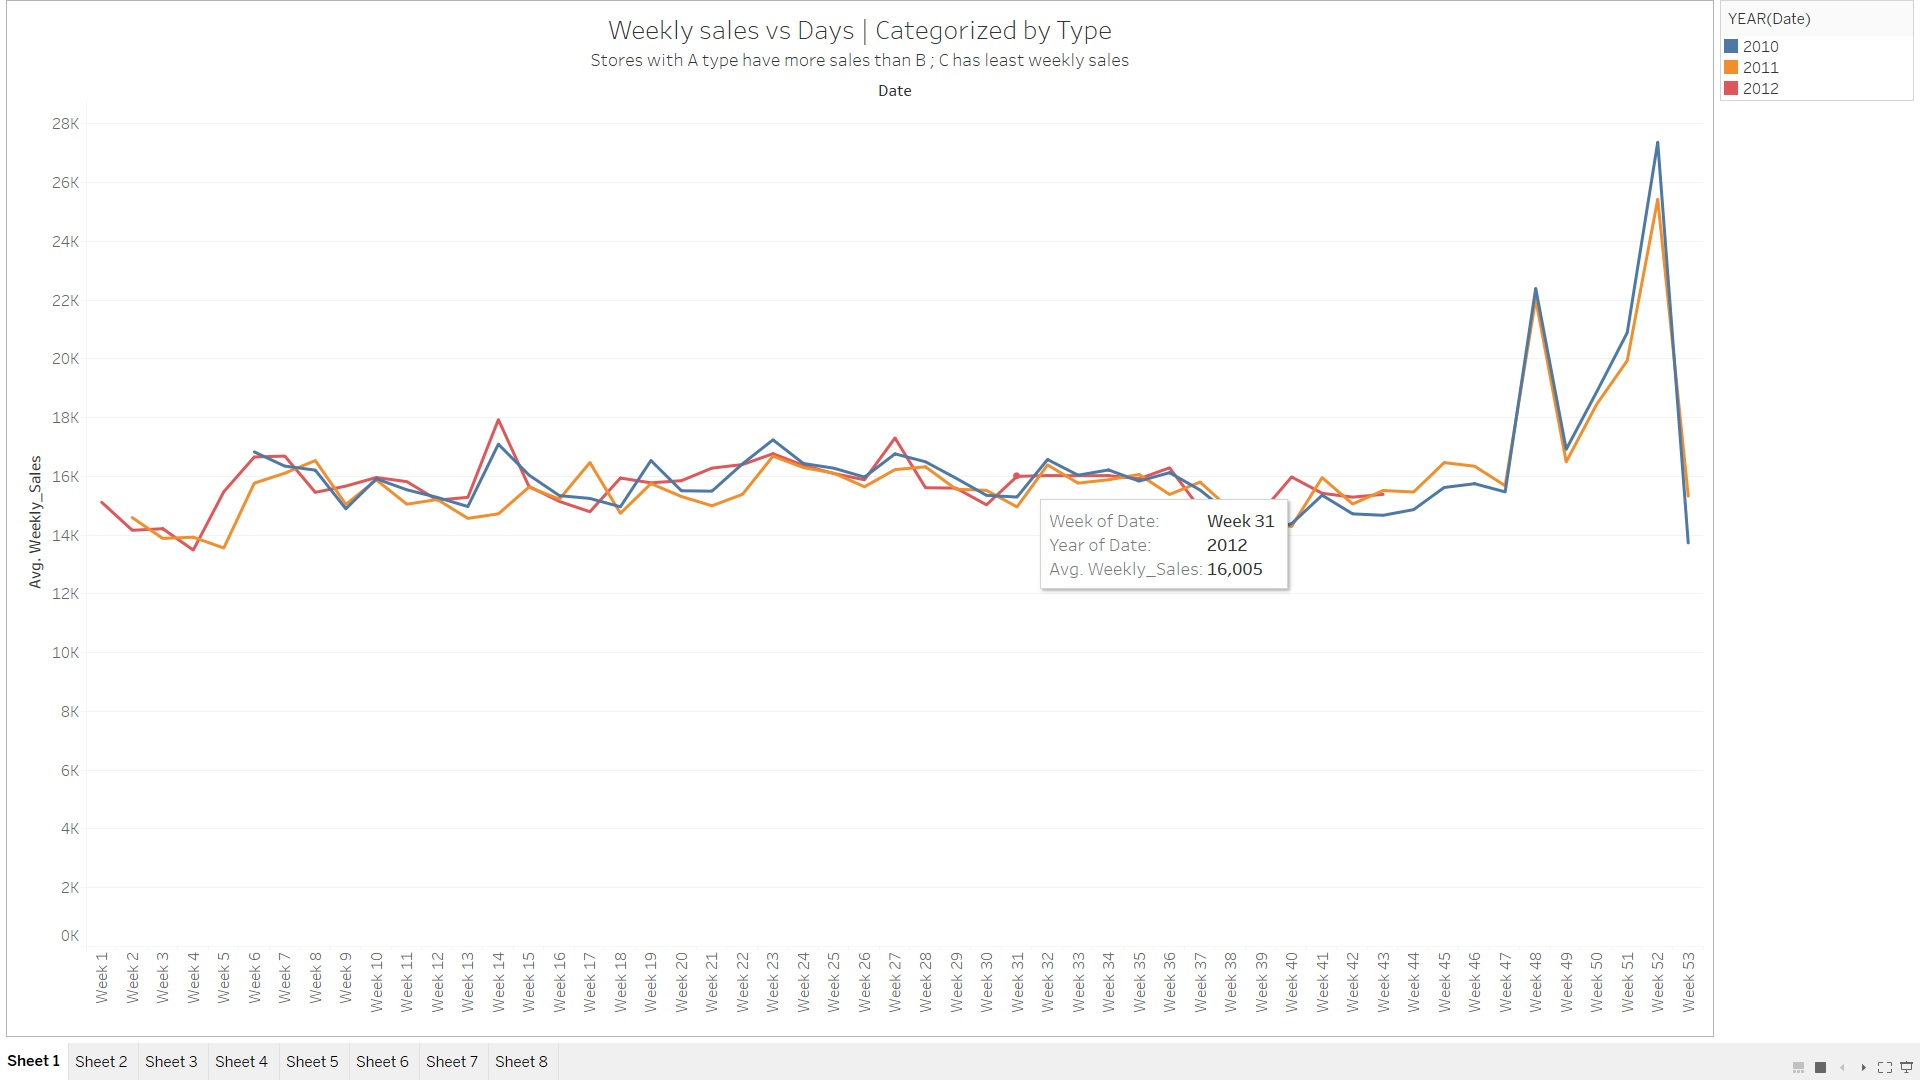

In [ ]:
display(Image(filename='/content/Weekly Sales.jpg'))

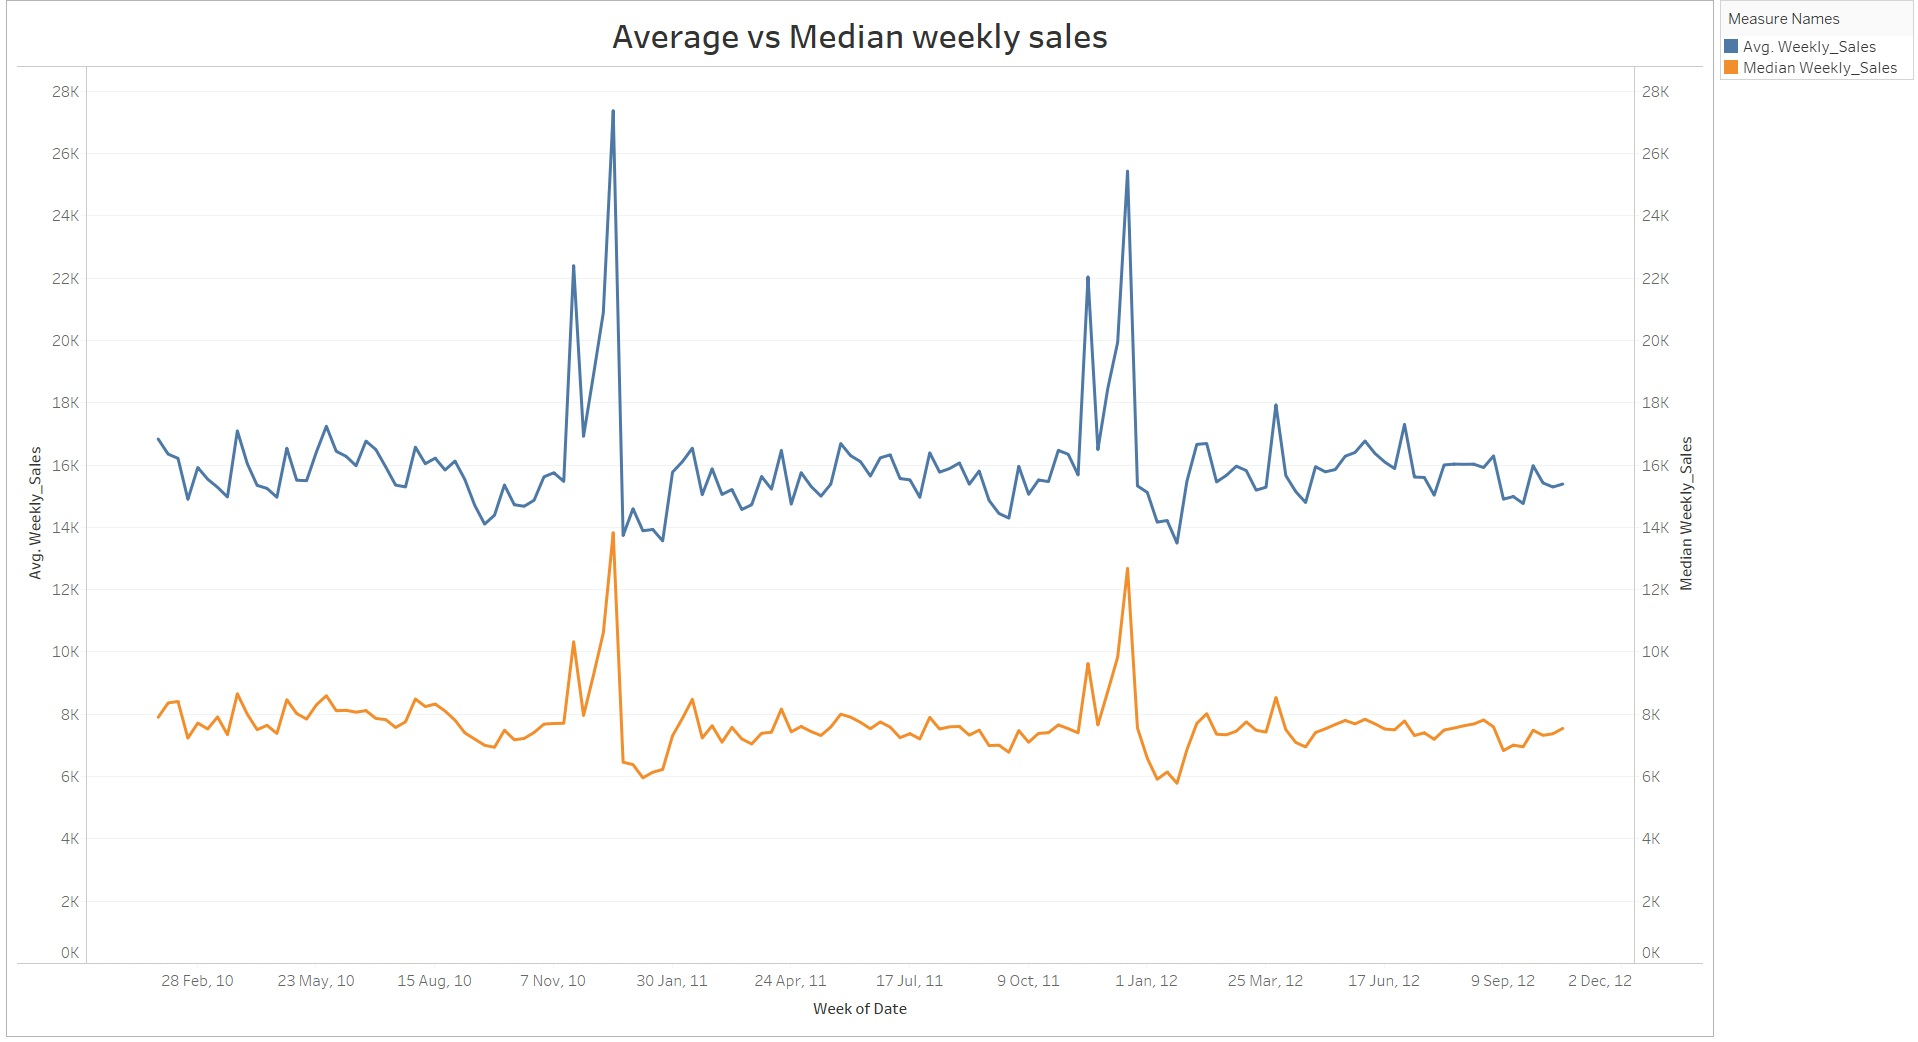

In [ ]:
display(Image(filename='/content/Average vs Median weekly sales.jpg'))

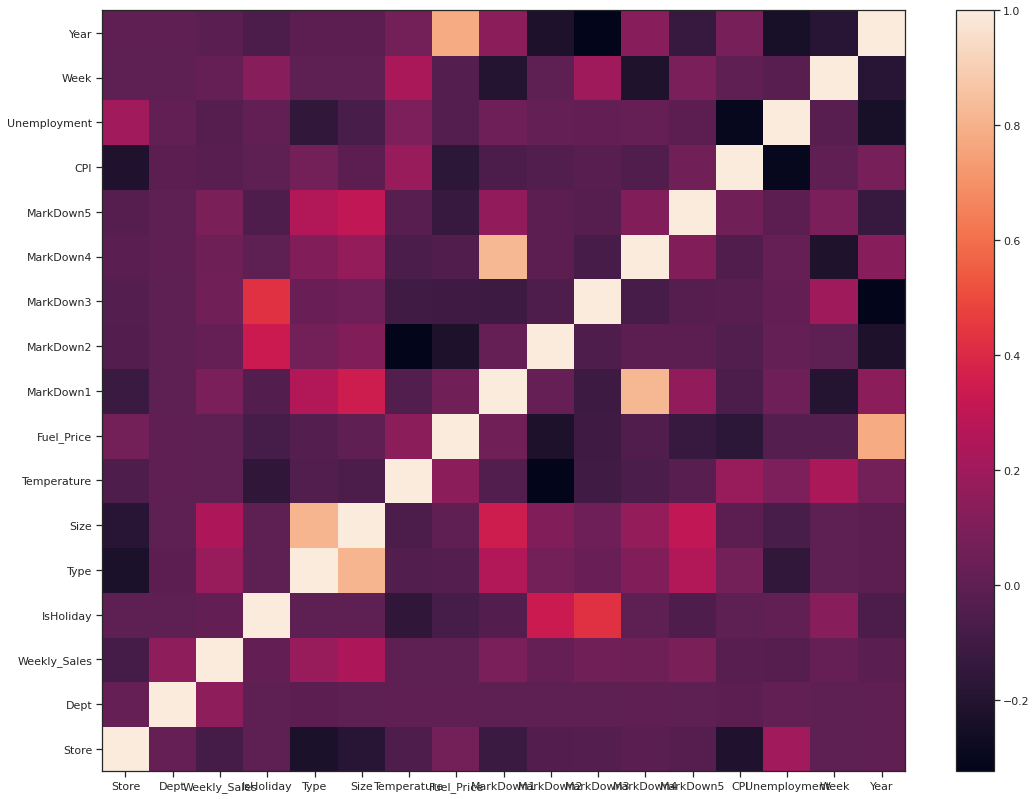

In [ ]:
fig = plt.figure(figsize=(18, 14))
corr = train_dataset.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

##Data cleaning

MarkDown' 1 to 5 are not strong correlated to 'Weekly_Sales' and they have a lot of null values, then we can drop them.

Also, 'Fuel_Price' is strong correlated to 'Year'. One of them must be dropped else they would carry similar information to the model. 'Year' will not be dropped, because it differentiate same Weeks for 'Store'+'Dept'.

Other variables that have weak correlation with 'Weekly_Sales' can be analyzed to see if they are useful.

In [ ]:
#dropping non required column

X_train = train_dataset[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_dataset['Weekly_Sales']

##Developing the model

The model chosen for this project is the Random Forest Regressor. It is an ensemble method and uses multiples decision trees ('n_estimators' parameter of the model) to determine final output, which is an average of the outputs of all trees.

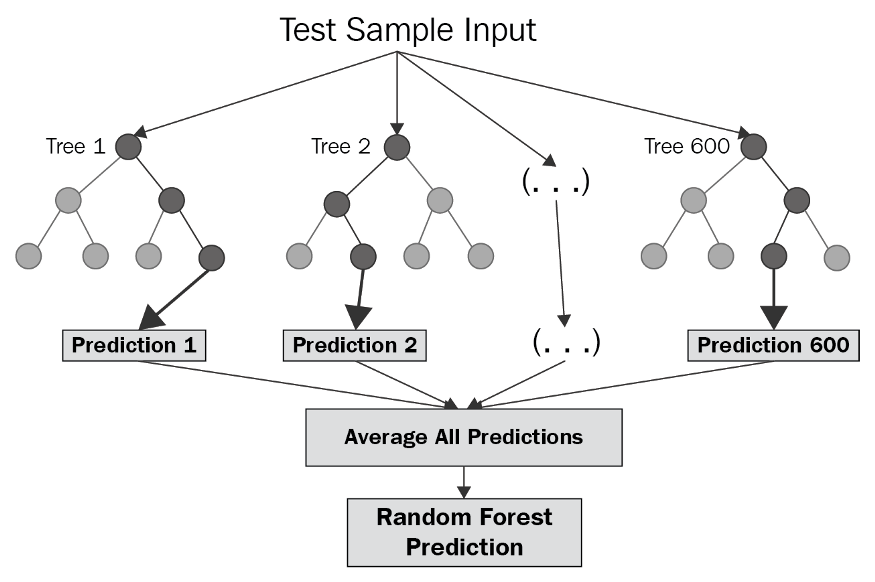

In [ ]:
display(Image(filename='/content/RandomForest.png'))

In [ ]:
#Loading libraries

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

The evaluation is based on Weighted Mean Absolute Error (WMAE), with a weight of 5 for Holiday Weeks and 1 otherwise.

So, turning the formula into a function, since we can't use GridSearchCV or RandomSearchCV:

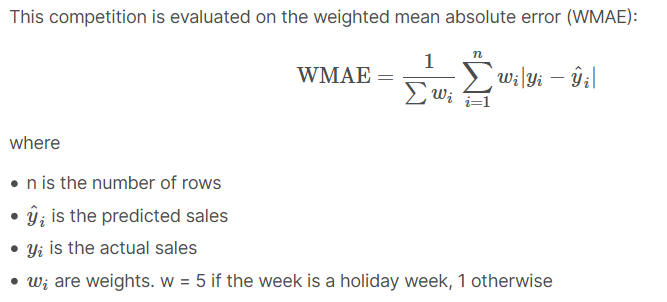

In [ ]:
display(Image(filename='/content/formula.png'))

In [ ]:
#Defining the result parameter

def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

It is important to tune these parameters to find the best predictor and to minimize overfitting.

The functions for Random Forest, Parameters Tuning and Cross Validation are:

In [ ]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,2):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [ ]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,2):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [ ]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,2):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

Tuning 'n_estimators' and 'max_depth'.

Here, it is possible to test a lot of values. Those are the final ones, after a bit of testing.

In [ ]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25


KeyboardInterrupt: ignored

The result by the time I run it is 58 and 30.

Tuning 'max_features'.

In [ ]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=58, max_depth= 30, max_features=max_features)

The result by the time I run it is 7.

Tuning 'min_samples_split' and 'min_samples_leaf'.

In [ ]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=30, max_features=7, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

In [ ]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=7, min_samples_split=2, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=27, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=58, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=7, min_samples_split=2, min_samples_leaf=1)
RF.fit(x_train, y_train)
predicted = RF.predict(x_test)y
WMAE(x_test, y_test, predicted)



1530.97

In [ ]:
all_test = x_test.merge(y_test,left_index=True,right_index=True).reset_index().drop(columns=['index'])
all_test

,Store,Dept,IsHoliday,Size,Week,Type,Year,Weekly_Sales
0,3,28,1,37392,52,1,2011,200.59
1,18,2,0,120653,8,1,2010,64838.86
2,10,95,0,126512,29,1,2010,80501.11
3,41,56,0,196321,26,1,2011,10614.05
4,17,74,0,93188,3,1,2011,12355.80
...,...,...,...,...,...,...,...,...
126466,40,2,0,155083,21,1,2012,25112.80
126467,32,40,0,203007,35,1,2011,56876.44
126468,28,58,0,206302,27,1,2011,4220.00
126469,32,5,0,203007,10,1,2012,21891.78


In [ ]:
predict

,0
0,247.605690
1,68895.049483
2,80808.152931
3,8797.903230
4,13035.372759
...,...
126466,24870.877931
126467,58077.812414
126468,5100.927931
126469,20327.411207


In [ ]:
temp = predict.merge(all_test,left_index=True,right_index=True)
temp.to_csv('Compare.csv')

It can be observed that Weeks 51 has difference between predicted and actual weekly sales as highest. Hence, we need to adjust the difference for christmas



In [ ]:
y_test.to_csv('Y_test.csv',index=True)
predict = pd.DataFrame(predicted)
predict.to_csv('predict.csv',index=True)

#Testing Data

In [ ]:
test_dataset = test.merge(stores, how='left',on=['Store']).merge(features, how='left',on=['Store','Date','IsHoliday'])

#Converting Dates to weeks and year
test_dataset['Week'] = pd.to_datetime(test['Date']).dt.week 
test_dataset['Year'] = pd.to_datetime(test['Date']).dt.year

#Convert type to categorical values to dummies
test_dataset['IsHoliday'] = test_dataset['IsHoliday'].astype(int)

#Convert Type to integer A=3, B=2, C=1
test_dataset.Type = test_dataset.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

X_test = test_dataset[['Store','Dept','IsHoliday','Size','Week','Type','Year']]

X_test

,Store,Dept,IsHoliday,Size,Week,Type,Year
0,1,1,0,151315,44,3,2012
1,1,1,0,151315,45,3,2012
2,1,1,0,151315,46,3,2012
3,1,1,1,151315,47,3,2012
4,1,1,0,151315,48,3,2012
...,...,...,...,...,...,...,...
115059,45,98,0,118221,26,2,2013
115060,45,98,0,118221,27,2,2013
115061,45,98,0,118221,28,2,2013
115062,45,98,0,118221,29,2,2013


In [ ]:
predict = RF.predict(X_test)
df_predict = pd.DataFrame(predict)
df_predict['Weekly_Sales']= df_predict
df_predict=df_predict.drop(columns=0)
df_predict

,Weekly_Sales
0,32249.789483
1,18981.580517
2,19269.866552
3,20668.662931
4,24030.223448
...,...
115059,676.273793
115060,671.125172
115061,696.573276
115062,770.879828


In [ ]:
result = X_test.merge(df_predict, left_index=True,right_index=True)

In [ ]:
Final = result.merge(test_dataset, how='left',on=['Store','Dept','IsHoliday','Size','Week','Type','Year'])

In [ ]:
submission = Final[['Date','Store','Dept','Weekly_Sales']]
submission['Id']= submission['Store'].astype(str) + "_" + submission['Dept'].astype(str) + "_" + submission['Date'].astype(str)
submission=submission[['Id','Weekly_Sales']]
submission

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,Weekly_Sales
0,1_1_2012-11-02,32249.789483
1,1_1_2012-11-09,18981.580517
2,1_1_2012-11-16,19269.866552
3,1_1_2012-11-23,20668.662931
4,1_1_2012-11-30,24030.223448
...,...,...
115059,45_98_2013-06-28,676.273793
115060,45_98_2013-07-05,671.125172
115061,45_98_2013-07-12,696.573276
115062,45_98_2013-07-19,770.879828


#Christmas Adjustment

We can remember that Christmas Week has 0 pre-holiday days in 2010, 1 in 2011 and 3 in 2012. So, it's a difference of 3 days from 2012 to 2010 and 2 days from 2012 to 2011. A 2.5 days average, in a week (7 days). So, this is the value that we are going to multiply to Week 51 and add to Week 52 to compensate what the model didn't take into account.

But we are going to use this formula just for 'Stores'+'Departments' that have a big difference between Week 51 and Week 52 Sales. Let's say Week51 > 2 * Week52.

Let's use another dataframe and SQL to solve it quickly.

In [ ]:
Final

,Store,Dept,IsHoliday,Size,Week,Type,Year,Weekly_Sales,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,0,151315,44,3,2012,32249.789483,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,0,151315,45,3,2012,18981.580517,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,0,151315,46,3,2012,19269.866552,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,1,151315,47,3,2012,20668.662931,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,0,151315,48,3,2012,24030.223448,2012-11-30,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,0,118221,26,2,2013,676.273793,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN
115060,45,98,0,118221,27,2,2013,671.125172,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN
115061,45,98,0,118221,28,2,2013,696.573276,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN
115062,45,98,0,118221,29,2,2013,770.879828,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN


In [ ]:
Final_adj = pysqldf("""
                            SELECT
                                Store,
                                Dept,
                                Week,
                                Weekly_Sales
                                case 
                                    when Week = 52 and last_sales > 2*Weekly_Sales then Weekly_Sales+(2.5/7)*last_sales
                                    else Weekly_Sales 
                                end as Weekly_Sales_Adjusted
                            from(
                                SELECT
                                    Store, 
                                    Dept, 
                                    Week, 
                                    Weekly_Sales,
                                    case 
                                        when Week = 52 then lag(Weekly_Sales) over(partition by Store, Dept) 
                                    end as last_sales
                                from Final)""") 

#Submission

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
!kaggle competitions submit -c walmart-recruiting-store-sales-forecasting -f submission.csv -m "Message"

100% 3.84M/3.84M [00:00<00:00, 11.0MB/s]
Successfully submitted to Walmart Recruiting - Store Sales Forecasting